# Mechanisms for metastable dynamics

This notebook contains Julia code for studying and playing around with some dynamical mechanisms for generating metastability, following the discussions in our paper. 

The mechanisms included here are:
1. Attractor-hopping: a bistable duffing oscillator driven by white noise
2. Heteroclinic cycle: there saddle points connected via their invariant manifolds
3. Intermittency due to attractor-merging crises

The notebook contains only parts of the whole code database I wrote for this project. For more details, check the open-access github repository at https://github.com/KalelR/metastability.

## 1. Attractor-hopping

We show here a simple example of a very general phenomenon in which a multistable system is subjected to unbounded noise. The noise kicks the trajectories from one attractor to another, leading to attractor-hopping dynamics. No attractor in this case is truly stable. If the amplitude of the noise is sufficiently weak, the trajectories stay in one attractor for a significant amount of time and then quickly hop to another attractor. Under some conditions, the residence times follows an exponential distribution, in a relation known as Kramer's law. 

The noisy bistable system we use is known as the noisy Duffing oscillator (see Strogatz, 2002), is given by:
$$
\begin{align}
    \dot{x} &= v + \eta_1 \dot{W}\\ 
    \dot{v} &= -ax^3 + bx -c -dv + f\cos(\omega t) + \eta_2 \dot{W},
\end{align}
$$ 

with $\dot{W}$ describing a white Gaussian noise. The equations describe the evolution of a particle on a double-well (quartic) potential $U(x) = ax^4/4 -bx^2/2 +cx$ being periodically driven and with noise.
The parameters used were $a=0.5$; $b=8.0$, $c=0.0$, $d = 0.2$, $f = 0.0$, $\omega = 1.0$, $\eta_1= \eta_2 = 0.18$, with initial condition $(0, 0)$. 

In the code below, we first define the rules for evolving the system, then integrate it and plot the x-coordinate along with the state space. Then we define the code for animating the ball on its potential landscape.


In [7]:
using GLMakie, DifferentialEquations

In [27]:
@inbounds function duffing_rule(du, u, p, t)
    a,b,c,d,f, ω, n₁, n₂ = p
    x, v = u
    du[1] = v
    du[2] = (-a*x^3 + b*x - c) - d*v + f*cos(ω*t)
end

@inbounds function duffing_noise_rule(du,u,p,t)
    a,b,c,d,f, ω, n₁, n₂ = p
    du[1] = n₁
    du[2] = n₂
end

"""
This function establishes the default parameters used in the simulations and then creates the structure in the code that is needed to numerically integrate.
"""
function noisy_duffing(; a=0.5, b=8.0, c=0.0, d = 0.2, f = 0.0, ω = 1.0, n₁ = 0.18, n₂ = n₁, T = 1e4, u0 = [0.0, 0.0])
    p =  [a, b, c, d, f, ω, n₁, n₂];
    prob_duffing = SDEProblem(duffing_rule, duffing_noise_rule, u0, (0, T), p; seed=0)
    return prob_duffing, p
end

noisy_duffing

In [28]:
T = 1e3
prob_duffing, p = noisy_duffing(; T); 

In [24]:
Δt = 0.1
sol = solve(prob_duffing, SKenCarp(), saveat=0:Δt:T);

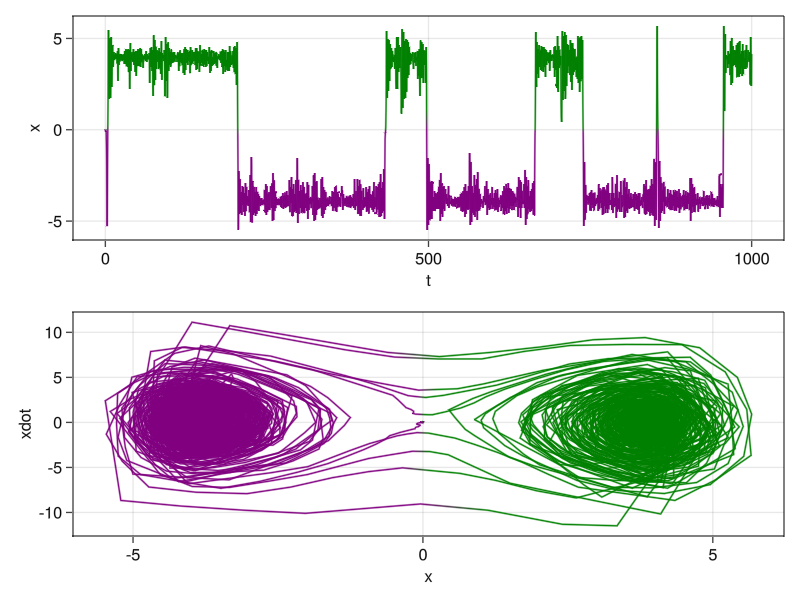

In [47]:
fig = Figure()
ax1 = Axis(fig[1, 1], ylabel="x", xlabel="t")
xs = sol[1,:]
ts = sol.t
color = [el > 0 ? :green : :purple for el in xs]
lines!(ax1, ts, xs; color)
ax2 = Axis(fig[2, 1], ylabel="xdot", xlabel="x")
xdots = sol[2,:]
lines!(ax2, xs, xdots; color)
fig

In [55]:


doublewell(x, a, b, c) = (a/4)*x^4 - (b/2) * x^2 + c*x
xs_plot = -6.5:0.1:6.5
Us = doublewell.(xs_plot, a, b, c)

a, b, c = p[1:3]
points_ax1 = Observable(Point2f[ (xs[1], doublewell(xs[1], a, b, c)) ])
points_ax2 = Observable(Point2f[ (ts[1], xs[1]) ])
time = Observable(ts[1])

fig = Figure(resolution=(800, 600))
ax1 = Axis(fig[1, 1], title= @lift("t = $($time)"))
c1 = "#440154FF"; c2 = "#FDE725FF"; cball = "#FF1400"; #colors for plots
lines!(ax1, xs_plot, Us, linewidth=4, color=[el > 0 ? c1 : c2 for el in xs_plot])
scatter!(ax1, points_ax1, color=cball, markersize=20)

ax2 = Axis(fig[2, 1], ylabel="x", xlabel="t")
lines!(ax2, ts, xs, color=[el > 0 ? c1 : c2 for el in xs])
scatter!(ax2, points_ax2, color=cball, markersize=20)

frames = 2:length(ts)
framerate = 75
record(fig, "noisybistable-animation.mp4", frames;
        framerate) do frame
    time[] = ts[frame]
    newpoint_ax1 = Point2f(xs[frame,1], doublewell(xs[frame,1], a, b, c))
    newpoint_ax2 = Point2f(ts[frame], xs[frame,1])
    points_ax1[] = [newpoint_ax1]
	points_ax2[] = [newpoint_ax2]
end

"noisybistable-animation.mp4"

In [54]:
#note to self: maybe animation can be plotted directly as in https://gist.github.com/Datseris/4b9d25a3ddb3936d3b83d3037f8188dd
using Base64
function display_mp4(filename)
    display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",
    base64encode(open(read,filename)),"""" type="video/mp4"></video>"""))
end
display_mp4("noisybistable-animation.mp4")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAoqJNtZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAEshZYiEACv//vbw/gU2O5jQlxHN6J0zH78VuLo0N73OAAADAAAjnyAAADpozpXGOqTD8aACDvbML3vmYQAFJEPe3jSC04m2cin8+qJd8OF4tAI5xBxq7JPJs8EVK2RCSZTkMXDNF+pd2WBwvKVY6q5VeSgxRv21kB7tvOKfVY/bHw1aWbMwuajzhIzpAHpmMdC8A40uhFZTCkS1dYTWaZ5ySTJ6W9kZFza++0EAJBRx2180Te43iHOBXJM8r16YGQd7LInSmkt24j5RuJje61wC/0PIvS40zAD+rpL3/SFsOF0oLr43Fade0+XSpRA+pHDregAAAwBcoxiCz4agsPNnej+neN6I8xN3ZX9WQaF43gOGJs99pqipw41uDQvl7pWyxTcvF9MwVVMhQwq7yjFkyrfvelwJR9XamVCiqioKoOYQjTAyNH62cRBN8uNrchrrq7lxxWWvn6KGtisDq3IM5Zisb5logza0cNV32/SFt45hbIFm449K0gvNS8zBXatbu7gcIxwUEIuKBeRmqhx4oSQb7xprb1YIeskmWsNHz/4xr0eqw/dOqZ4IC70QnJcdKnFeMbf6coW6ScDfHHR/y2Ba1p40OpsnPqOgZjVA0vLYv1vXVa369CAJ4sI5iOrr3W2wb8/FXzO7bxDWkpct7pDyi3GG+rUyWO3J6JrQXeG6E+f2Flr+TiddqzLFluguaFQ9bjhpO8WDm+O2hxVSrx5tnKfCBjkzUeQyt4WvVaKn0hbaQk+8kxPjcsBIwwTX3+kwsNEWAnUYN2o6U5eYDGHM7A0Co+WKfACFGdkwuoj6oKDrs9nJZe8Ak+fP8WNeEnIhgtqoxFmGAqtyiSbyS8UgoHJ3uELjxqGf8cc/647Hw0UKjWlHOiV9Xh0vy7LG/G8ZOKSyHXexF+9ypkSMTtql8GLKUkm4iYXh03me8RisLc61oC+X/bHGPs4JioUeQEEz/87kENwWo7EowVACq2/ALYP9dVl2PnhVD+1NNHLSvtH4R86AcIukjPPQFDyw8viKAjETOCQq1JZP2qkHAFwgIxfqQXzHUKQRb15/KDt0fTNeaBkNoegnUjAeQ2YlPih1agIJdfT2Oso9BfWFm1ekJB89GhMrCP7BNWrRqNlC500i3umMQ+ZEX1FOtbLyp89q/P2dmfG9WLan1fzREJSpKivzUW3efUEL97CWuniYrngeHpPno9a8ypws7sWAAwDRWIX6QcDbArxFnO4UAyVW1JY5fG4MMGaAelEE0j99sfCiVnLI+EObNYRHg0uPUpbx4D8fFId7SvbzJXdHU91RVX/iCv9HDJFy+vuDlfDFSatQwTaQGFgaBezMHh6AHwkaY69ZWUFIgEuSC/oOAWNq1U2WYsdwudJKSdImF0PHWQ++1vBTP6Z2mRl6HSso+JRqh9RE1C71QLsKv/yj2R/v43fhimBTAFHWfNLrcKj2T3cRi5Ko4papILZWzUmwdDXqX29uPCzD0TXYaWFfqwLXGgD4RPOd6Er6PQwuHYWBnl0kCcAq0xoJSAb3QqufJSkvKFH09ZnTSlj57LkjszsTHhNjGrv182QqdJti5UoBTS/Om05a00bTTltslYyIII9/yxDN/ojiV8peE1EFZGDBhQKp8Hir9IWRWW5Atw8jlKvW6jFfvyKdm/3TbOONK59VgaY6BW/HR0FEpo0rfANDS2MZWq0jBgAEaHYjiDM/+4VJq/TqQ4PLQ10scKLBaseAgT9se9ZV/UuU12new9DFbGJz07dfn4mrMHE+wckC2RNbG5G4tAIQ075GPwv8CBTqn+j1Z4GmgIj3IFShefuwHgNLXYPoHAxL7zNuVMAldJTpTbPgtwPwUWevQG+jG5B6Z955ZPPnMkOtq3fNOCLpGbZZzxLTCPjp+2KNVLrkzCAdQrvMkful4hFpQ1NDH3OLqDOMAo3T+R8/oP8g0NMWbro2YObHCfNothIs1rb9GJ5+4pOa7weBPnya7aQaELJ9GUoAKXBWfvZfNfsDaIpoaPZSQACq+EZZZFTj3N+Sg1vU55DL/FQSw7DbNIsI/XVQ0XEG9s46u/1kGgPXQCGCWqfMdP8D2nhgzE0B+QbSC8dlzzLtN9hEqi2izMJsCyJY7dhdG92Q+1H1DgU4B9W0nrnU28QiyjUM7IbeMTyNaGoZwDR/HWV/gL6tQnbFLID2Fa/q87+z5fgFNwjshL4CZoyclEBT/XdgRtJcMH6U3K/xGnrJONwe8bK1+6+MoZYu3Euarv650Erqu+i1+eUauqQF+YKTBfoFwMCZMcAfD6m0Y5hoq/7b1iAnHgiZY5jxPRd6mfBW00RS2lIkhRW4wevOeukILDCUtvt/AuY8jtkYF/jm0ZXnMCyKVNHDXh60STwjlmXus0r0awjCLnMNhA08XTOFhsx4WICDlAF8DtLIo8I6BVTWXqjvEz0BAF9Z7XPS1aAJ+TOlnkkAA7yh66IQ6yqhABPngAeUF+o5e/cOylM6jtl7Y3yFYIToGuqHr0srtr8NUBOrvQIXfD2qzdPUxvqVUS3Septyp7Mll41spFboXFcsmvj+eQlny2i6EPcsi72zdtL0RgfThmQi6a0QqKtoDTOTqS+aESjkoNPouyVpOgot2zLPPo1IGBP2jzWqisjRPor7cyDwiv6akZ39JeA0lv+pu9ds4t9Ss8zZzyzCMZpdWk59JxVOzsZ4eL9SpQZ/UQUdy0V8yTFzf1o0d7W7BoOwqUIbK0uVARvRouduFtLLgcVsWgx5R2HR3jEawVmQDx86V/FMoqfb/Zov8G9XcIYuebOfaoUnQTQyFA+MmbS7b5ZCQIW2qZfHmNWo2H9uQHeEoyDBcQW2lX9gOM2ve0sJQdojGVnpk6r7ukQYyghd1z6fxWteWTWjCxCphx9GaCe/7xmX9obmQ6AbGnd9nxBmRfZUrKsDewVce1+YQrHwc/prybIFHFaQi+echFSE+mfK2xpccW3fWpV8g18PTfG8ZxjtZQE1R/R

## Heteroclinic cycle

A stable heteroclinic cycle is an attractor of the system. The trajectories on the cycle alternate between the three saddle fixed points. Each saddle has distinct properties (their position in state space), and the duration near them is long, so each saddle is a metastable state.

The heteroclinic cycle we show here occurs in a rate model derived from Hodgkin-Huxley type neurons with synaptic coupling \cite{ashwin2011criteria}. The equations are given by:
$$
\begin{align}
\tau\dot{s_i} &= \left( r_i - s_i/2 \right) \frac{S_\mathrm{max} - s_i}{S_\mathrm{max}} \\
\tau\dot{r_i} &= x_0 F\left( I - \sum_{j=1}^N g_{ij} s_j \right) \tau - r_i \\
\end{align}
$$

for $i = 1, 2, 3$, with 
$$
\begin{equation}
    F(x) = \exp(-\epsilon/x) [\max(0, x)^\alpha ]. 
\end{equation}
$$ 

The matrix $g$ is constructed such that $g_{21} = g_{32} = g_{13} = g_1$, $g_{12} = g_{23} = g_{31} = g_2$ and $g_{11} = g_{22} = g_{33} = 0$. The parameters are $\tau = 50$, $\epsilon = 10^{-3}$, $I = 0.145$, $S_\mathrm{max} = 0.045$, $g_1 = 3.0$, $g_2 = 0.7$, $x_0 = 2.57 \times 10^{-3}$, and $\alpha = 0.564$.

The numerical integration is best done with a change of coordinates $z_i \equiv \log(S_\mathrm{max} - s_i)$, which reduces the numerical precision difficulties associated with the trajectory getting too close to the stable manifold of the fixed points. The initial condition was $(0.5, 0.2, 0.4, 0.9, 0.5, 0.6)$. 



In [64]:
z_to_s(z, Smax) = Smax - exp(z);

mutable struct ratemodel_params
    gs :: Matrix{Float64}
    I :: Float64
    ϵ :: Float64
    Smax :: Float64
    τ :: Float64
    x₀ :: Float64
    α :: Float64
end

function ratemodel_params()
    N = 3
    τ = 50.
    ϵ = 1e-3
    I = 0.145
    Smax = 0.045
    g₁ = 3.0
    g₂ = 0.7
    x₀ = 2.57e-3
    α = 0.564
    gs = zeros(Float64, (3,3))
    gs[2,1] = gs[3,2] = gs[1,3] = g₁
    gs[1,2] = gs[2,3] = gs[3,1] = g₂
    gs[1,1] = gs[2,2] = gs[3,3] = 0.
    return ratemodel_params(gs, I, ϵ, Smax, τ, x₀, α)
end

@inbounds function ratemodel_Z_coupling(gi, Zs, Smax)
    Isyn = 0.0
    for j = 1:length(Zs)
        Isyn += gi[j] * (Smax - exp(Zs[j]))
    end
    return Isyn
end

function F(x, ϵ, α)
    if x ≤ 0 return 0.0 end
    return exp(-ϵ/x) * x^α
end

@inbounds function ratemodel_Z!(du, u, p, t)
    Smax = p.Smax; x₀ = p.x₀; I = p.I; gs = p.gs; τ = p.τ; ϵ = p.ϵ; α = p.α
    N = size(gs, 1)
    for i=1:N
        Z, r = @view u[(i-1)*2 + 1 : i*2]
        Zs = @view u[((1:N) .-1) .*2 .+ 1]
        gi = @view gs[i,:]
        du[(i-1)*2 + 1] = (1/(τ*Smax)) * ( ((Smax - exp(Z))/2) - r)
        du[(i-1)*2 + 2] = x₀ * F(I - ratemodel_Z_coupling(gi, Zs, Smax), ϵ, α) - r/τ
    end
    return nothing
end

function heteroclinic_cycle(; u0 = [0.5, 0.2, 0.4, 0.9, 0.5, 0.6], T = 1e6)
    p = ratemodel_params()
    tspan = (0, T);
    hcgh = ODEProblem(ratemodel_Z!, u0, tspan, p);
    return hcgh, p
end

heteroclinic_cycle (generic function with 1 method)

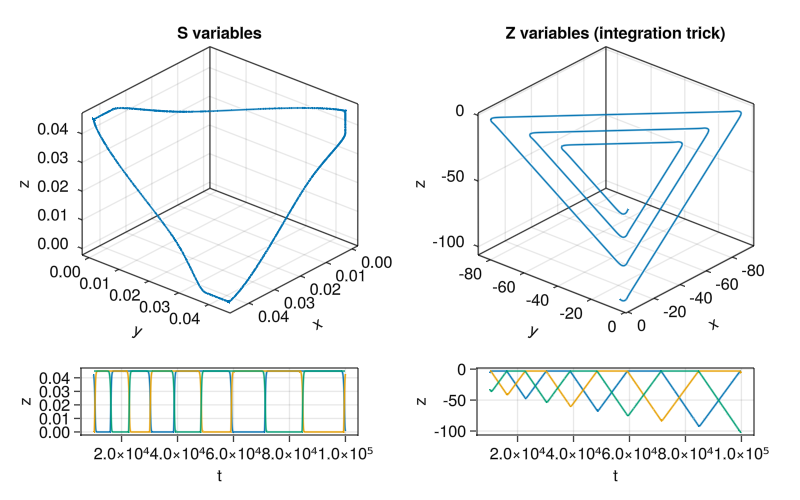

In [105]:
T = 1e5
Ttr = 1e4
Δt = 1.0
hcgh, p = heteroclinic_cycle(); N = size(p.gs, 1)
sol = solve(hcgh, Vern9(), maxiters=1e9, saveat=Ttr:Δt:T); 
ts = sol.t;
zs = @view sol[((1:N) .-1) .*2 .+ 1, :];
ss = map(x->z_to_s(x, p.Smax), zs); #coordinate transformation

azimuth = 6.995530633326985; elevation = 0.3926990816987241
fig = Figure(resolution=(800, 500))
ax1 = Axis3(fig[1, 1]; title="S variables (real system)", azimuth, elevation, viewmode=:stretch);
lines!(ax1, ss[1,:], ss[2,:], ss[3,:]);

ax2 = Axis(fig[2, 1]; ylabel="z", xlabel="t" );
for i=1:3 lines!(ax2, ts, ss[i,:]) end

ax3 = Axis3(fig[1, 2]; title="Z variables (integration trick)", azimuth, elevation, viewmode=:stretch);
lines!(ax3, zs[1,:], zs[2,:], zs[3,:]);

ax4 = Axis(fig[2, 2]; ylabel="z", xlabel="t");
for i=1:3 lines!(ax4, ts, zs[i,:]) end


rowsize!(fig.layout, 1, Relative(0.8))
fig

Animation for this case has too many dependent functions. Way easier to run it from code available in GitHub.

In [108]:
function dwelltimes_heteroclinicycle(xs, ys, zs, fps; neigh_th = 0.001)
    traj_state_idxs_all = classify_points_into_fps([xs ys zs]', fps[1:2:end, :]; neigh_th);
    dwelltimes, _ = length_samevalues_allowfluctuations(traj_state_idxs_all); #dwell times in each saddle
    return traj_state_idxs_all, dwelltimes
end

function color_trajectory_hc(traj_state_idxs_all; c1=:purple, c2=:green, c3=:orange, fpalpha=1.0, trajcolor=:blue)
    fp_colors = [(c1, fpalpha), (c2, fpalpha), (c3, fpalpha)];
    traj_colors = replace(traj_state_idxs_all, (0:3 .=> [trajcolor; fp_colors])...); #get colors for trajectory
    return fp_colors, traj_colors
end

function fixedpoints_ratemodel(p)
    Smax = p.Smax
    r1 = 0.00866; r2 = 0.03733; r3 = 0.0;
    fp1 = [0 r3 Smax r2 Smax r1];
    fp2 = [Smax r2 Smax r1 0 r3];
    fp3 = [Smax r1 0 r3 Smax r2];
    fps = [fp1; fp2; fp3]';
end

""" for each point in the trajectory, assign to closest fixed point if within neigh_th; otherwise classify as transition point
fps[:, j] needs to be the j-th fixed point
traj[:,j] needs to be the j-th point in the trajectory (at time t[j]) ie cols contains the state space points
"""
function classify_points_into_fps(traj, fps; neigh_th=0.5)
    traj_state_idxs = zeros(Int, size(traj, 2))
    for (i, pt) in enumerate(eachcol(traj) )
        state = 0 #transition
        for j=1:3
            if iswithinneighborhood(pt, fps[:, j], neigh_th)  state = j end
        end
        traj_state_idxs[i] = state
    end
    return traj_state_idxs
end

"""utility: create matrix traj to be used in classify points"""
function classify_points_into_fps_from_sol(sol, fps, tplot=0; neigh_th)
    if tplot == 0 tplot = size(sol, 2) end
    sol_a = sol[:, 1:tplot];
    zs_a = @view sol_a[((1:N) .-1) .*2 .+ 1, :]; ss_a = map(x->z_to_s(x, Smax), zs_a); rs_a = @view sol_a[((1:N) .-1) .*2 .+ 2, :];
    traj = zeros(Float64, (size(sol_a))); traj[1:2:end, :] .= ss_a; traj[2:2:end, :] .= rs_a;
    traj_state_idxs = classify_points_into_fps(traj, fps; neigh_th = 0.01);
end


function animate_heterolinic_cycle(filename, ts, xs, ys, zs, fps; framerate=100, numframes=100, alphalines = 1.0, mksize=12,
    az=0.78, el = 0.31, c1 = :green, c2 = :purple, c3=:red, fulltrajcolor=:black)
    xyz_points = Observable(Point3f[(xs[1], ys[1], zs[1])])
    tx_points = Observable(Point2f[(ts[1], xs[1])])
    ty_points = Observable(Point2f[(ts[1], ys[1])])
    tz_points = Observable(Point2f[(ts[1], zs[1])])
    tanim = Observable(ts[1])

    traj_state_idxs_all, dwelltimes = dwelltimes_heteroclinicycle(xs, ys, zs, fps; neigh_th=0.001)
    fp_colors,  traj_colors = color_trajectory_hc(traj_state_idxs_all; c1, c2, c3, trajcolor=fulltrajcolor)
# traj_colors = :black

    fig = Figure(resolution=(800, 600)); axs = [];
    ax = Axis3(fig[1:2,1:3], azimuth = az, elevation = el, title= @lift("t = $($tanim)")); push!(axs, ax);

    lines!(ax, xs, ys, zs, color=fulltrajcolor) #full trajectory, black line
    scatter!(ax, fps[1:2:end, :][:,1], fps[1:2:end, :][:, 2], fps[1:2:end, :][:, 3], color=[c1, c2, c3], markersize=mksize+4)
    scatter!(ax, xyz_points, color=:orange, markersize=mksize, overdraw=true)
    hidedecorations!(ax, ticks=false, label=false, ticklabels=false)


    ax = Axis(fig[3,1], xlabel="t", ylabel="x", xticks = WilkinsonTicks(3)); push!(axs, ax);
    lines!(ax, ts, xs, color=traj_colors)
    scatter!(ax, tx_points, color=(:orange, 1.0), markersize=mksize)
    hidespines!(ax, :t, :r)

    ax = Axis(fig[3,2], xlabel="t", ylabel="y"); push!(axs, ax);
    lines!(ax, ts, ys, color=traj_colors)
    scatter!(ax, ty_points, color=(:orange, 1.0), markersize=mksize)
    hidespines!(ax, :t, :r)

    ax = Axis(fig[3,3], xlabel="t", ylabel="z"); push!(axs, ax);
    lines!(ax, ts, zs, color=traj_colors)
    scatter!(ax, tz_points, color=(:orange, 1.0), markersize=mksize)
    hidespines!(ax, :t, :r)
    linkxaxes!(axs[2:end]...)
    linkyaxes!(axs[2:end]...)
    for i=2:4 axs[i].xticks = [minimum(ts), (maximum(ts)+minimum(ts))/2, maximum(ts)] end


    mkpath(dirname(filename))
    ts_iterator = floor.(Int, range(1, length(ts), length=numframes))
    record(fig, filename, ts_iterator; framerate) do idx_t
        tanim[] = ts[idx_t]
        new_xyz_point = Point3f(xs[idx_t], ys[idx_t], zs[idx_t])
        new_tx_point = Point2f(ts[idx_t], xs[idx_t])
        new_ty_point = Point2f(ts[idx_t], ys[idx_t])
        new_tz_point = Point2f(ts[idx_t], zs[idx_t])
        xyz_points[] = [new_xyz_point]
        tx_points[] = [new_tx_point]
        ty_points[] = [new_ty_point]
        tz_points[] = [new_tz_point]
    end
end

Ttr = 50000; T = 100000; Δt= 1.0;
sol = solve(hcgh, Vern9(), maxiters=1e9, saveat=Ttr:Δt:T); 
ts = sol.t;
zs = @view sol[((1:N) .-1) .*2 .+ 1, :];
ss = map(x->z_to_s(x, p.Smax), zs); #coordinate transformation

fps = fixedpoints_ratemodel(p)
az = 6.995530633326985; el = 0.3926990816987241
framerate = 25; numframes = 400
filename = "heterocliniccycle.mp4"
animate_heterolinic_cycle(filename, ts, ss[1, :], ss[2, :], ss[3, :], fps; framerate, numframes, az, el)
display_mp4(filename)

LoadError: UndefVarError: iswithinneighborhood not defined

## Intermittency due to attractor-merging crises

At an attractor-merging crises, two previously-separated-attractors A and B merge to form a single attractor AB. Soon after the crises, however, the trajectories spend long times where one of the attractors used to exist, then switch to where the other attractor existed, and keep intermittently switching between these regions. Phenomenologically, this is similar to a bistable case with noise or an external drive causing this hopping. Fundamentally, however, the two processes are different: in the crises, the switching is deterministic. 

We have provided an example of attractor-merging crisis for the Duffing oscillator without noise, whose dynamics is described by \cite{ishii1986breakdown}: 

$$
\begin{align}
    \dot{x} &= v \\ 
    \dot{v} &= -ax^3 + bx -dv + f \cos(\omega t) 
\end{align}
$$ 

with parameters $a = 100$, $b = 10$, $d = 1.0$, $f = 0.852$, $\omega = 3.5$ and initial condition $(x,v) = (0.11, 0.11)$.


In [ ]:
function plot_time_series()
    # T = 100000
    T = 1e6
    Ttr = 100000
    Δt=0.05
    tplot = 1000;

    parameters_ishii1986 = Dict(
        :a => 100, #b in their paper
        :b => 10, #-a in the paper
        :c => 0.0, #not present there (symmetric wells)
        :d => 1.0, # γ in their paper
        # :f => 0.853, #F
        :f => 0.852, #F
        # :f => 0.849, #F
        :ω => 3.5, #Ω
    )

    # Time series
    diffeq = (alg = Tsit5(), abstol=1e-8, reltol=1e-8, maxiters=1e8)
    u0 = [0.1, 0.1]
    cleft = :purple
    cright = :green
    fig, axs = subplotgrid(3, 1; resolution=(columnsize_pt, 2.0*columnsize_pt), xlabels=["t", "x", ""], ylabels=["x", "dx/dt", "PDF(τ)"], sharex=false, sharey=false)
    df = duffing_assymetric(parameters_ishii1986)
    tr = trajectory(df, T, u0; Ttr, Δt, diffeq); 
    ts = Ttr:Δt:Ttr+T; xs = tr[:,1]; ys = tr[:,2];
    time_idxs_plot = floor(Int64, T - tplot/Δt):1:ceil(Int64, T)
    ts_plot = ts[time_idxs_plot]; xs_plot = xs[time_idxs_plot]; ys_plot = ys[time_idxs_plot]
    idx_states_time_plot = [x >= 0 ? 1 : 0 for x in xs_plot]
    colors = replace(idx_states_time_plot, 1=>cright, 0=>cleft)

    ax = axs[1]
    lines!(ax, ts_plot, xs_plot, color=colors, linewidth=0.7)
    ax.xticks = [10000, 10500, 11000]
    # ylims!(ax, -0.6, 0.6)

    ax = axs[2]
    lines!(ax, xs_plot, ys_plot, color=colors)
    ax.xlabel = "x"
    rowsize!(fig.layout, 2, Relative(0.6))
    
    ax = axs[3] 
    ax.xlabel = "τ"
    idx_states_time = [x >= 0 ? 1 : 0 for x in xs]
    numbins = 10;
    for (i, key) in enumerate([0, 1])
    dwelltimes = length_samevalues_allowfluctuations(idx_states_time, 3)[1][key]
    weights, bins = histogram(dwelltimes, collect(range(0, 4000; length=numbins)))
    weights .+=1e-8
    lines!(ax, bins, weights, color=[cleft, cright][i])
    end
    ax.yscale = log10
    ax.xticks = 0:2000:4000
    save("$(plotsdir())/paper/intermittency-attractormergingcrisis.pdf", fig)
    fig
end

fig = plot_time_series()